In [15]:
import numpy as np
import rasterio as rs
from rasterio.mask import mask
import requests
from io import BytesIO
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# path to shape file
mask_path = 'CANARC_MI.shp'
site_path = 'sites.shp'

# For file saving:
maskLocation = 'CANARC_MI_5km'

# Load shape files for the sites and masks
site_gpd = gpd.read_file(site_path)
mask_gpd = gpd.read_file(mask_path)
mask_gpd = mask_gpd.to_crs('EPSG:3413')  # Match the projections to the sea ice

# Grab the important stuff
canarc_bs = site_gpd.iloc[0]
bs_mask = mask_gpd.iloc[0].geometry

# years for processing:
years = ['2021']
process_months = [1,2,3,4,5,6,7,8,9,10,11,12]  # Edit as needed


# specific_dates = {
#     '2013': ('2013-09-14','2013-10-07'),
#     '2014': ('2014-07-25','2014-09-09','2014-10-04'),
#     '2015': ('2015-06-05','2015-08-30','2015-09-12','2015-10-12'),
#     '2016': ('2016-07-03','2016-07-13'),
#     '2017': ('2017-09-03','2017-10-01'),
#     '2018': ('2018-07-04','2018-09-05')
# }


# Assuming non-leap year; adjust February to 29 for leap years.
months_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
months_str = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Initialize a dictionary to store mean values
mean_values_by_date = {}

def reproject_raster(src, target_crs):
    '''
    Change CRS of imported data.
    Input: Source data (src), which is a raster. Every file that we are downloading, is a .tif.
    Output: Reprojected data (previously raw, now is still a raster with values but in the projection we want), a transformed matrix.
    Additionally it also gives you the target CRS to keep track.
    '''
    src_crs = src.crs
    src_transform = src.transform
    src_width = src.width
    src_height = src.height

    # Reproject the raster data to the target CRS
    reprojected_data, dst_transform = rs.warp.reproject(
        source=rs.band(src, 1),
        src_transform=src_transform,
        src_crs=src_crs,
        dst_crs=target_crs,
        resampling=rs.enums.Resampling.nearest)
    
    return reprojected_data, dst_transform, target_crs

# Loop through each year, month and day:
for year in years:
    for month_index, days_in_month in enumerate(months_days):
        month_int = month_index + 1 
        if month_int in process_months:  # Will filter for the specified months.
            month_str = months_str[month_index]
            for day in range(1, days_in_month + 1):
                date = f'{year}{month_int:02d}{day:02d}'
                url = f'https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/n3125/{year}/{month_str}/Arctic3125/asi-AMSR2-n3125-{date}-v5.4.tif'
                print(f'Accessing data for {date}: {url}')

                # Request and process data for each day
                response = requests.get(url)
                if response.status_code == 200:
                    today_seaice_raw = rs.open(BytesIO(response.content))
                    today_seaice_3995, transform_3995, crs_3995 = reproject_raster(today_seaice_raw, 'EPSG:3995')

                    # Apply the masks
                    masked_bs, transform_bs = mask(today_seaice_raw, [bs_mask], pad=False, crop=True, nodata=255)

                    # Calculate mean sea ice concentration, excluding land and mask values
                    bs_mean = np.mean(masked_bs[0][(masked_bs[0] != 255) & (masked_bs[0] !=120)])
                    mean_values_by_date[date] = {'bs_mean': bs_mean}
                else:
                    print(f'Failed to download data for {date}')
                    mean_values_by_date[date] = {'bs_mean': np.nan}

    # Convert the dictionary to a DataFrame and plot
    df = pd.DataFrame.from_dict(mean_values_by_date, orient='index', columns=['bs_mean'])
    df.index = pd.to_datetime(df.index)

    # Save csv:
    # csv_path = f'E:/CANARC_All/ice_data/CANARC_MI/{maskLocation}/{year}_{maskLocation}_Arctic3125_3125Km.csv'
    # df.to_csv(csv_path, index=True, index_label='Date')
    # print(f'Data saved to {csv_path}')

# Loop through each year to plot and save ice concentrations:

for year in years:
    # Filter dataframe by year
    df_year = df[df.index.year == int(year)]

    # Plot and save ice concentrations:
    plt.figure(figsize=(10, 6))
    plt.plot(df_year.index, df_year['bs_mean'], label='Daily mean', marker='x')
    plt.title(f'Daily Sea Ice Concentration in {year} for {maskLocation}')
    plt.xlabel('Date')
    plt.ylabel('Mean Sea Ice %')
    plt.legend()
    plt.xticks(rotation=45)

    # # Add dots for specific dates
    # for specific_year, specific_dates_list in specific_dates.items():  
    #     for specific_date in specific_dates_list:
    #         if specific_date in df_year.index:
    #             plt.plot(df_year.index[df_year.index == specific_date], df_year['bs_mean'][df_year.index == specific_date], 'ro')
    
    plt.tight_layout()
    #plt.savefig(f'E:/CANARC_All/ice_data/CANARC_BS/{maskLocation}/CANARC_BS_{year}_{maskLocation}_MeanIceConcentration.png')
    #plt.savefig(f'E:/CANARC_All/ice_data/CANARC_MI/{maskLocation}/{year}_{maskLocation}_MeanIceConcentration.png')
    plt.close()

plt.show()

Accessing data for 20210101: https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/n3125/2021/jan/Arctic3125/asi-AMSR2-n3125-20210101-v5.4.tif
Accessing data for 20210102: https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/n3125/2021/jan/Arctic3125/asi-AMSR2-n3125-20210102-v5.4.tif
Accessing data for 20210103: https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/n3125/2021/jan/Arctic3125/asi-AMSR2-n3125-20210103-v5.4.tif
Accessing data for 20210104: https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/n3125/2021/jan/Arctic3125/asi-AMSR2-n3125-20210104-v5.4.tif
Accessing data for 20210105: https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/n3125/2021/jan/Arctic3125/asi-AMSR2-n3125-20210105-v5.4.tif
Accessing data for 20210106: https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/n3125/2021/jan/Arctic3125/asi-AMSR2-n3125-20210106-v5.4.tif
Accessing data for 20210107: https://data.seaice.uni-bremen.de/amsr2/asi_daygrid_swath/n3125/2021/jan/Arctic3125/asi-A

In [2]:
  # Save csv:
csv_path = f'E:/CANARC_All/ice_data/CANARC_MI/{maskLocation}/{year}_{maskLocation}_Arctic3125_3125Km.csv'
df.to_csv(csv_path, index=True, index_label='Date')
print(f'Data saved to {csv_path}')


Data saved to E:/CANARC_All/ice_data/CANARC_MI/CANARC_MI_5km/2023_CANARC_MI_5km_Arctic3125_3125Km.csv


Daily mean SIC plots saved to E:/CANARC_All/ice_data/CANARC_MI/CANARC_MI_5km/2023_CANARC_MI_5km_Arctic3125_3125Km.csv


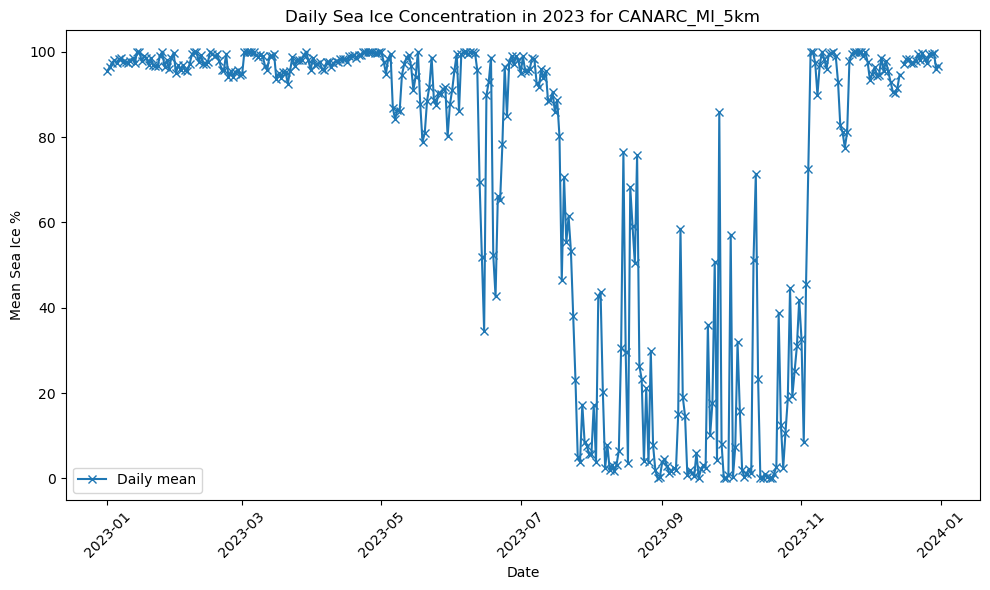

In [3]:
# Loop through each year to plot and save ice concentrations:

for year in years:
    # Filter dataframe by year
    df_year = df[df.index.year == int(year)]

    # Plot and save ice concentrations:
    plt.figure(figsize=(10, 6))
    plt.plot(df_year.index, df_year['bs_mean'], label='Daily mean', marker='x')
    plt.title(f'Daily Sea Ice Concentration in {year} for {maskLocation}')
    plt.xlabel('Date')
    plt.ylabel('Mean Sea Ice %')
    plt.legend()
    plt.xticks(rotation=45)

    # # Add dots for specific dates
    # for specific_year, specific_dates_list in specific_dates.items():  
    #     for specific_date in specific_dates_list:
    #         if specific_date in df_year.index:
    #             plt.plot(df_year.index[df_year.index == specific_date], df_year['bs_mean'][df_year.index == specific_date], 'ro')
    
    plt.tight_layout()
    #plt.savefig(f'E:/CANARC_All/ice_data/CANARC_BS/{maskLocation}/CANARC_BS_{year}_{maskLocation}_MeanIceConcentration.png')
    plt.savefig(f'E:/CANARC_All/ice_data/CANARC_MI/{maskLocation}/{year}_{maskLocation}_MeanIceConcentration.png')
    plt.close

print(f'Daily mean SIC plots saved to {csv_path}')

In [10]:
masked_bs, transform_bs = mask(today_seaice_raw, [bs_mask], pad=False, crop=True)

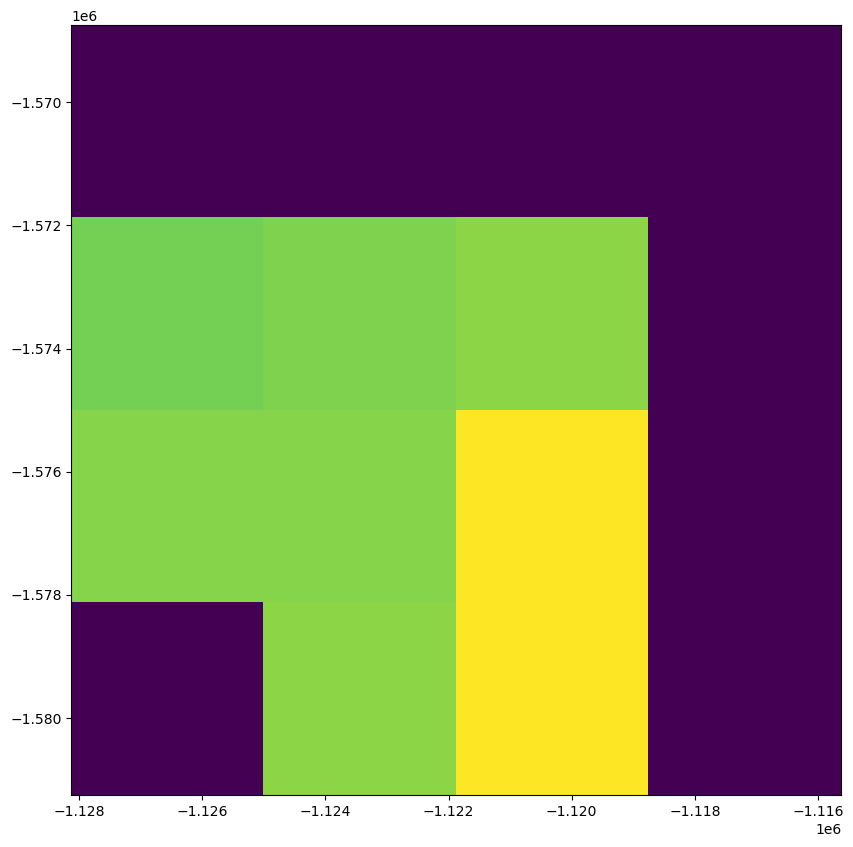

In [11]:
from rasterio.plot import show

fig, ax = plt.subplots(figsize=(10, 10))
show(masked_bs, transform=transform_bs, cmap='viridis', ax=ax)

#plt.savefig(f'E:/CANARC_All/ice_data/CANARC_BS/{maskLocation}/CANARC_BS_{maskLocation}.png')
plt.savefig(f'E:/CANARC_All/ice_data/CANARC_MI/{maskLocation}/{year}_{maskLocation}_mask.png')
#plt.savefig(f'E:/CANARC_All/ice_data/CANARC_BS/LS_Modes/CANARC_BS_{maskLocation}.png')

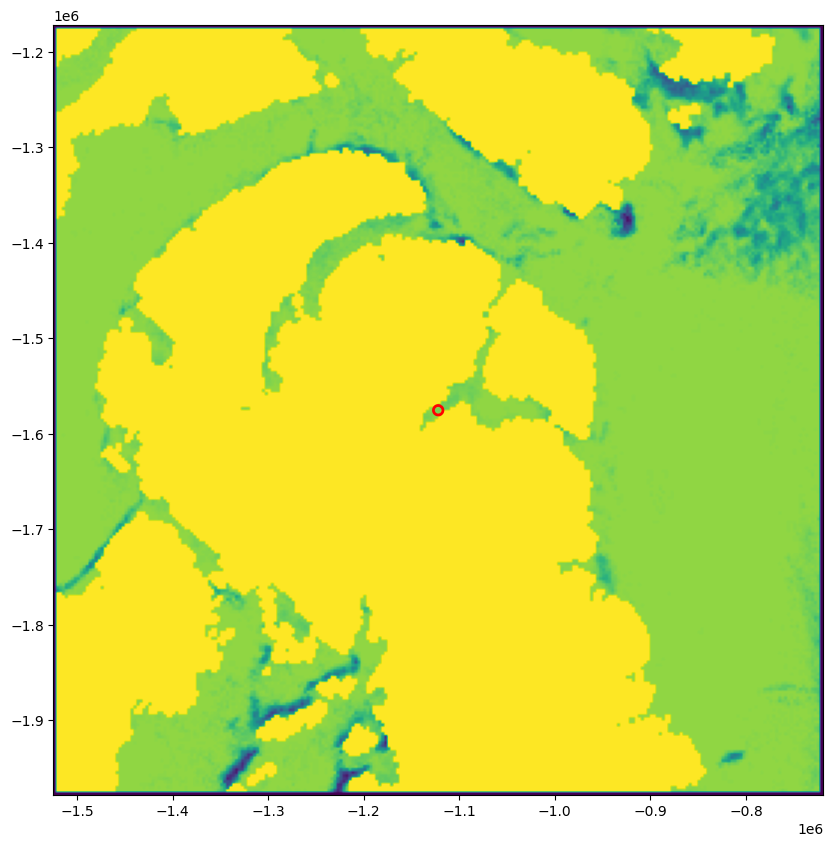

In [16]:
from shapely.geometry import box, Polygon

minx, miny, maxx, maxy = mask_gpd.to_crs('EPSG:3413').total_bounds
percent_buffer = 4000
xbuf, ybuf = np.abs((minx-maxx)*(percent_buffer/100)), np.abs((miny-maxy)*(percent_buffer/100))
new_square_mask = box(minx-xbuf, miny-ybuf, maxx+xbuf, maxy+ybuf)
#new_square_mask_gdf = gpd.GeoDataFrame({'geometry': [new_square_mask]}, crs=mask_gpd.to_crs('EPSG:3413').crs)

cropped, cropped_transform = mask(today_seaice_raw, [new_square_mask], pad=True, crop=True)

fig, ax = plt.subplots(figsize=(10, 10))
show(cropped, transform=cropped_transform, cmap='viridis', ax=ax)
mask_gpd.to_crs('EPSG:3413').plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

#plt.savefig(f'E:/CANARC_All/ice_data/CANARC_BS/{maskLocation}/CANARC_BS_{maskLocation}_All.png')
plt.savefig(f'E:/CANARC_All/ice_data/CANARC_MI/{maskLocation}/{year}_{maskLocation}_map.png')

#plt.savefig(f'E:/CANARC_All/ice_data/CANARC_BS/LS_Modes/CANARC_BS_{maskLocation}_All.png')

In [13]:
print(year)

2022


In [8]:
print(today_seaice_raw)
list(today_seaice_raw)

<open DatasetReader name='/vsipythonfilelike/15b75f42-aecc-457d-a017-73a573671145/15b75f42-aecc-457d-a017-73a573671145' mode='r'>


TypeError: 'DatasetReader' object is not iterable

In [ ]:
open(today_seaice_raw)

In [ ]:
img_arr = np.array(masked_bs)
print(img_arr)